### <b>Augmented 
Ref : <br>
https://pytorch.org/vision/main/transforms.html <br>
https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

try to use some Augmented method that can make the object clearly visible with a background 

In [1]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = 'tight'
orig_img = Image.open("test.jpg")

def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False , figsize=(10, 5))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

<b>ColorJitter

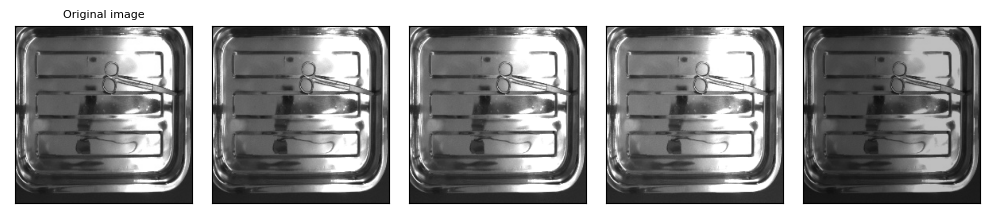

In [2]:
jitter = T.ColorJitter(brightness=.5, hue=.3)
jitted_imgs = [jitter(orig_img) for _ in range(4)]
plot(jitted_imgs)

<b> RandomInvert

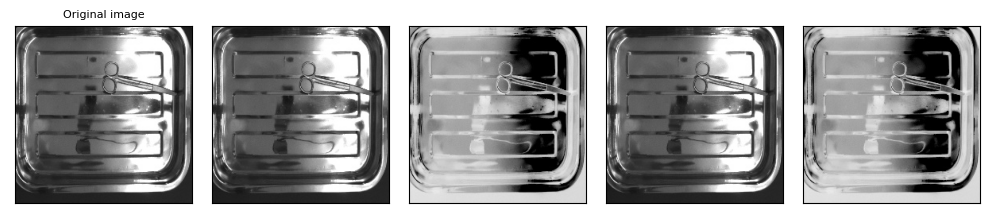

In [3]:
inverter = T.RandomInvert()
invertered_imgs = [inverter(orig_img) for _ in range(4)]
plot(invertered_imgs)

<b> RandomPosterize

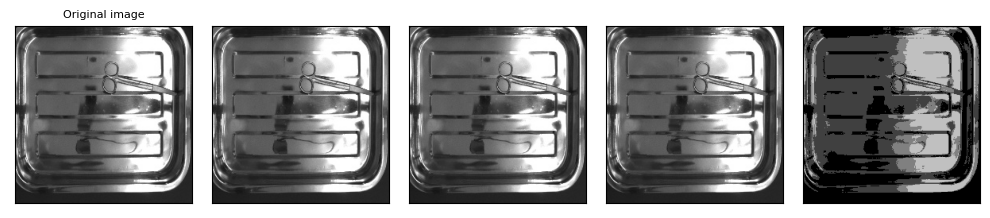

In [4]:
posterizer = T.RandomPosterize(bits=2)
posterized_imgs = [posterizer(orig_img) for _ in range(4)]
plot(posterized_imgs)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
from tqdm import tqdm

GPU device

In [6]:
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev) 
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 2060


<b> Load and Augment Data

In [7]:
Augmented_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.RandomPosterize(bits=2),
    transforms.RandomInvert(),
    transforms.ToTensor()
])


transform = transforms.Compose([
    transforms.ToTensor()
])

In [8]:
BATCH_SIZE = 16
TRAIN_DATA_PATH = "C:/Users/gmita/Desktop/work_3_2_2565/onboard/pytorch_ver/Data/train"
VAL_DATA_PATH = "C:/Users/gmita/Desktop/work_3_2_2565/onboard/pytorch_ver/Data/val"
TEST_DATA_PATH = "C:/Users/gmita/Desktop/work_3_2_2565/onboard/pytorch_ver/Data/Test"

In [9]:
train_Aug_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=Augmented_transform)
train_Aug_loader = torch.utils.data.DataLoader(train_Aug_data, batch_size=BATCH_SIZE,num_workers=0, shuffle=True,pin_memory=True)

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,num_workers=0, shuffle=True,pin_memory=True)
                                    
val_data = torchvision.datasets.ImageFolder(root=VAL_DATA_PATH, transform=transform)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE,num_workers=0,  shuffle=True,pin_memory=True)
                                    
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE,num_workers=0,  shuffle=False,pin_memory=True)

<b> Model <br>
1. VGG16
2. ResNet50

load pretain model

In [10]:
vgg16 = torchvision.models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg16_aug = torchvision.models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

resnet50 = torchvision.models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet50_aug = torchvision.models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)


Freeze weight model

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [12]:
#set seed
torch.manual_seed(666)
if torch.cuda.is_available():
    torch.cuda.manual_seed(666)

# set random seed for NumPy
np.random.seed(666)

In [13]:
set_parameter_requires_grad(vgg16 ,True)
set_parameter_requires_grad(resnet50 ,True)
set_parameter_requires_grad(vgg16_aug ,True)
set_parameter_requires_grad(resnet50_aug ,True)

vgg16.classifier = nn.Sequential(
          nn.Linear(25088,128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Linear(128,4),
          nn.Softmax(dim=1)
        )

vgg16_aug.classifier = nn.Sequential(
          nn.Linear(25088,128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Linear(128,4),
          nn.Softmax(dim=1)
        )

resnet50.fc = nn.Sequential(
          nn.Linear(2048,128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Linear(128,4),
          nn.Softmax(dim=1)
        )

resnet50_aug.fc = nn.Sequential(
          nn.Linear(2048,128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Linear(128,4),
          nn.Softmax(dim=1)
        )

Model Summary

In [14]:
from torchsummary import summary

summary(vgg16.cuda(), (3, 224, 224), 16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 224, 224]           1,792
              ReLU-2         [16, 64, 224, 224]               0
            Conv2d-3         [16, 64, 224, 224]          36,928
              ReLU-4         [16, 64, 224, 224]               0
         MaxPool2d-5         [16, 64, 112, 112]               0
            Conv2d-6        [16, 128, 112, 112]          73,856
              ReLU-7        [16, 128, 112, 112]               0
            Conv2d-8        [16, 128, 112, 112]         147,584
              ReLU-9        [16, 128, 112, 112]               0
        MaxPool2d-10          [16, 128, 56, 56]               0
           Conv2d-11          [16, 256, 56, 56]         295,168
             ReLU-12          [16, 256, 56, 56]               0
           Conv2d-13          [16, 256, 56, 56]         590,080
             ReLU-14          [16, 256,

In [15]:
summary(resnet50.cuda(), (3, 224, 224), 16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 112, 112]           9,408
       BatchNorm2d-2         [16, 64, 112, 112]             128
              ReLU-3         [16, 64, 112, 112]               0
         MaxPool2d-4           [16, 64, 56, 56]               0
            Conv2d-5           [16, 64, 56, 56]           4,096
       BatchNorm2d-6           [16, 64, 56, 56]             128
              ReLU-7           [16, 64, 56, 56]               0
            Conv2d-8           [16, 64, 56, 56]          36,864
       BatchNorm2d-9           [16, 64, 56, 56]             128
             ReLU-10           [16, 64, 56, 56]               0
           Conv2d-11          [16, 256, 56, 56]          16,384
      BatchNorm2d-12          [16, 256, 56, 56]             512
           Conv2d-13          [16, 256, 56, 56]          16,384
      BatchNorm2d-14          [16, 256,

In [16]:
optimizer_vgg = optim.SGD(vgg16.parameters(), momentum=0.9, lr=0.001)
optimizer_resnet50 = optim.SGD(resnet50.parameters(), momentum=0.9, lr=0.001)

optimizer_vgg_aug = optim.SGD(vgg16_aug.parameters(), momentum=0.9, lr=0.001)
optimizer_resnet50_aug = optim.SGD(resnet50_aug.parameters(), momentum=0.9, lr=0.001)

criterion = nn.functional.cross_entropy

Train model

In [17]:
from module import train , testAccuracy

train(30,vgg16,optimizer_vgg,criterion,train_loader,val_loader,"VGG16_nonAugmented.pt")

The model will be running on NVIDIA GeForce RTX 2060 device


Epoch 1/30: 100%|███████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.96it/s, Loss=1.08]


For epoch 1, the test accuracy over the whole validation set is 90.0% and loss 0.9339967186634357


Epoch 2/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.39it/s, Loss=0.837]


For epoch 2, the test accuracy over the whole validation set is 94.5% and loss 0.8198327559691209


Epoch 3/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.23it/s, Loss=0.797]


For epoch 3, the test accuracy over the whole validation set is 94.5% and loss 0.8241300582885742


Epoch 4/30: 100%|███████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.43it/s, Loss=0.78]


For epoch 4, the test accuracy over the whole validation set is 97.5% and loss 0.7859254800356351


Epoch 5/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.37it/s, Loss=0.774]


For epoch 5, the test accuracy over the whole validation set is 95.5% and loss 0.7902534512373117


Epoch 6/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.42it/s, Loss=0.762]


For epoch 6, the test accuracy over the whole validation set is 95.5% and loss 0.7920518196546115


Epoch 7/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.17it/s, Loss=0.758]


For epoch 7, the test accuracy over the whole validation set is 95.5% and loss 0.7870420034115131


Epoch 8/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.25it/s, Loss=0.756]


For epoch 8, the test accuracy over the whole validation set is 95.5% and loss 0.7924421521333548


Epoch 9/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.11it/s, Loss=0.753]


For epoch 9, the test accuracy over the whole validation set is 95.0% and loss 0.7885239720344543


Epoch 10/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.34it/s, Loss=0.751]


For epoch 10, the test accuracy over the whole validation set is 95.0% and loss 0.7852594210551336


Epoch 11/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.31it/s, Loss=0.751]


For epoch 11, the test accuracy over the whole validation set is 96.5% and loss 0.785138712479518


Epoch 12/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.11it/s, Loss=0.749]


For epoch 12, the test accuracy over the whole validation set is 97.0% and loss 0.7798087092546316


Epoch 13/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.32it/s, Loss=0.748]


For epoch 13, the test accuracy over the whole validation set is 96.5% and loss 0.7806079341815069


Epoch 14/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.28it/s, Loss=0.747]


For epoch 14, the test accuracy over the whole validation set is 96.5% and loss 0.7780134265239422


Epoch 15/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.18it/s, Loss=0.747]


For epoch 15, the test accuracy over the whole validation set is 97.5% and loss 0.7749435168046218


Epoch 16/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.19it/s, Loss=0.747]


For epoch 16, the test accuracy over the whole validation set is 97.5% and loss 0.7788485884666443


Epoch 17/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.99it/s, Loss=0.747]


For epoch 17, the test accuracy over the whole validation set is 97.5% and loss 0.7760064693597647


Epoch 18/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.02it/s, Loss=0.746]


For epoch 18, the test accuracy over the whole validation set is 97.0% and loss 0.7764271176778353


Epoch 19/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.19it/s, Loss=0.746]


For epoch 19, the test accuracy over the whole validation set is 97.0% and loss 0.7772866762601413


Epoch 20/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.11it/s, Loss=0.746]


For epoch 20, the test accuracy over the whole validation set is 97.5% and loss 0.7759624398671664


Epoch 21/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.12it/s, Loss=0.746]


For epoch 21, the test accuracy over the whole validation set is 96.5% and loss 0.7778762074617239


Epoch 22/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.12it/s, Loss=0.746]


For epoch 22, the test accuracy over the whole validation set is 97.0% and loss 0.7754683127770057


Epoch 23/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.18it/s, Loss=0.745]


For epoch 23, the test accuracy over the whole validation set is 97.5% and loss 0.7751985513246976


Epoch 24/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.92it/s, Loss=0.745]


For epoch 24, the test accuracy over the whole validation set is 97.0% and loss 0.7801373280011691


Epoch 25/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.14it/s, Loss=0.745]


For epoch 25, the test accuracy over the whole validation set is 97.0% and loss 0.775389171563662


Epoch 26/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.03it/s, Loss=0.745]


For epoch 26, the test accuracy over the whole validation set is 97.0% and loss 0.7750157301242535


Epoch 27/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:08<00:00, 10.98it/s, Loss=0.745]


For epoch 27, the test accuracy over the whole validation set is 97.0% and loss 0.7750737437835107


Epoch 28/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.05it/s, Loss=0.745]


For epoch 28, the test accuracy over the whole validation set is 97.0% and loss 0.7745878329643836


Epoch 29/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.13it/s, Loss=0.745]


For epoch 29, the test accuracy over the whole validation set is 97.0% and loss 0.7745649860455439


Epoch 30/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.23it/s, Loss=0.745]


For epoch 30, the test accuracy over the whole validation set is 97.5% and loss 0.7765604670231159
Training complete!
Total training time: 270.64 seconds


In [18]:
train(30,resnet50,optimizer_resnet50,criterion,train_loader,val_loader,"ResNet50_nonAugmented.pt")

The model will be running on NVIDIA GeForce RTX 2060 device


Epoch 1/30: 100%|███████████████████████████████████████████████████████████| 88/88 [00:06<00:00, 14.66it/s, Loss=1.27]


For epoch 1, the test accuracy over the whole validation set is 78.5% and loss 1.1378975739845862


Epoch 2/30: 100%|██████████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.37it/s, Loss=1]


For epoch 2, the test accuracy over the whole validation set is 88.5% and loss 0.9065405405484713


Epoch 3/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.40it/s, Loss=0.895]


For epoch 3, the test accuracy over the whole validation set is 94.0% and loss 0.8463527606083796


Epoch 4/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.25it/s, Loss=0.856]


For epoch 4, the test accuracy over the whole validation set is 96.0% and loss 0.8219650112665616


Epoch 5/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.48it/s, Loss=0.828]


For epoch 5, the test accuracy over the whole validation set is 95.5% and loss 0.8194215664496789


Epoch 6/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.48it/s, Loss=0.818]


For epoch 6, the test accuracy over the whole validation set is 96.0% and loss 0.8172384042006272


Epoch 7/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.48it/s, Loss=0.812]


For epoch 7, the test accuracy over the whole validation set is 96.5% and loss 0.8111314406761756


Epoch 8/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.51it/s, Loss=0.803]


For epoch 8, the test accuracy over the whole validation set is 96.0% and loss 0.8042517579518832


Epoch 9/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.32it/s, Loss=0.801]


For epoch 9, the test accuracy over the whole validation set is 96.0% and loss 0.7976678472298843


Epoch 10/30: 100%|███████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.41it/s, Loss=0.8]


For epoch 10, the test accuracy over the whole validation set is 95.5% and loss 0.8011044630637536


Epoch 11/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.36it/s, Loss=0.795]


For epoch 11, the test accuracy over the whole validation set is 96.0% and loss 0.801671917621906


Epoch 12/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.47it/s, Loss=0.795]


For epoch 12, the test accuracy over the whole validation set is 95.5% and loss 0.7958005529183608


Epoch 13/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.44it/s, Loss=0.791]


For epoch 13, the test accuracy over the whole validation set is 96.5% and loss 0.7917750294391925


Epoch 14/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.46it/s, Loss=0.791]


For epoch 14, the test accuracy over the whole validation set is 95.5% and loss 0.7974924353452829


Epoch 15/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.46it/s, Loss=0.789]


For epoch 15, the test accuracy over the whole validation set is 95.5% and loss 0.801460536626669


Epoch 16/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.52it/s, Loss=0.788]


For epoch 16, the test accuracy over the whole validation set is 95.0% and loss 0.7975702698414142


Epoch 17/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.51it/s, Loss=0.788]


For epoch 17, the test accuracy over the whole validation set is 96.5% and loss 0.7951716368014996


Epoch 18/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.46it/s, Loss=0.787]


For epoch 18, the test accuracy over the whole validation set is 96.0% and loss 0.7903609642615685


Epoch 19/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.44it/s, Loss=0.787]


For epoch 19, the test accuracy over the whole validation set is 95.5% and loss 0.791112693456503


Epoch 20/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.40it/s, Loss=0.786]


For epoch 20, the test accuracy over the whole validation set is 95.5% and loss 0.7925354334024283


Epoch 21/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.24it/s, Loss=0.785]


For epoch 21, the test accuracy over the whole validation set is 95.5% and loss 0.7917868311588581


Epoch 22/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.39it/s, Loss=0.784]


For epoch 22, the test accuracy over the whole validation set is 95.5% and loss 0.7882057703458346


Epoch 23/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.41it/s, Loss=0.784]


For epoch 23, the test accuracy over the whole validation set is 95.5% and loss 0.791014029429509


Epoch 24/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.40it/s, Loss=0.783]


For epoch 24, the test accuracy over the whole validation set is 95.5% and loss 0.7914299139609704


Epoch 25/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.34it/s, Loss=0.783]


For epoch 25, the test accuracy over the whole validation set is 96.0% and loss 0.7926650597498968


Epoch 26/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.36it/s, Loss=0.782]


For epoch 26, the test accuracy over the whole validation set is 95.5% and loss 0.790431416951693


Epoch 27/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.38it/s, Loss=0.782]


For epoch 27, the test accuracy over the whole validation set is 95.0% and loss 0.8003473281860352


Epoch 28/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.40it/s, Loss=0.782]


For epoch 28, the test accuracy over the whole validation set is 96.5% and loss 0.7884998734180744


Epoch 29/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.39it/s, Loss=0.781]


For epoch 29, the test accuracy over the whole validation set is 95.0% and loss 0.796553698869852


Epoch 30/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 15.35it/s, Loss=0.781]


For epoch 30, the test accuracy over the whole validation set is 95.5% and loss 0.78815758228302
Training complete!
Total training time: 197.66 seconds


In [19]:
train(30,vgg16_aug,optimizer_vgg_aug,criterion,train_Aug_loader,val_loader,"VGG16_Augmented.pt")

The model will be running on NVIDIA GeForce RTX 2060 device


Epoch 1/30: 100%|███████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.89it/s, Loss=1.18]


For epoch 1, the test accuracy over the whole validation set is 82.5% and loss 1.0002528153933012


Epoch 2/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.99it/s, Loss=0.954]


For epoch 2, the test accuracy over the whole validation set is 85.0% and loss 0.8916501127756559


Epoch 3/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.97it/s, Loss=0.875]


For epoch 3, the test accuracy over the whole validation set is 89.0% and loss 0.8560733199119568


Epoch 4/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.93it/s, Loss=0.839]


For epoch 4, the test accuracy over the whole validation set is 91.0% and loss 0.8405057466947116


Epoch 5/30: 100%|███████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.97it/s, Loss=0.83]


For epoch 5, the test accuracy over the whole validation set is 93.5% and loss 0.8146529472791232


Epoch 6/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.95it/s, Loss=0.825]


For epoch 6, the test accuracy over the whole validation set is 91.0% and loss 0.8330346254202036


Epoch 7/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.92it/s, Loss=0.809]


For epoch 7, the test accuracy over the whole validation set is 92.0% and loss 0.824403281395252


Epoch 8/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.93it/s, Loss=0.804]


For epoch 8, the test accuracy over the whole validation set is 93.0% and loss 0.8143576566989605


Epoch 9/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.00it/s, Loss=0.796]


For epoch 9, the test accuracy over the whole validation set is 94.0% and loss 0.8162647439883306


Epoch 10/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.93it/s, Loss=0.791]


For epoch 10, the test accuracy over the whole validation set is 92.5% and loss 0.8185440118496234


Epoch 11/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.94it/s, Loss=0.798]


For epoch 11, the test accuracy over the whole validation set is 93.5% and loss 0.8275253818585322


Epoch 12/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.99it/s, Loss=0.786]


For epoch 12, the test accuracy over the whole validation set is 93.5% and loss 0.8064190882902879


Epoch 13/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.99it/s, Loss=0.788]


For epoch 13, the test accuracy over the whole validation set is 93.5% and loss 0.8088685136574966


Epoch 14/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.00it/s, Loss=0.782]


For epoch 14, the test accuracy over the whole validation set is 93.0% and loss 0.805574907706334


Epoch 15/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.94it/s, Loss=0.776]


For epoch 15, the test accuracy over the whole validation set is 93.0% and loss 0.8080759461109455


Epoch 16/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.02it/s, Loss=0.78]


For epoch 16, the test accuracy over the whole validation set is 94.0% and loss 0.8017017474541297


Epoch 17/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.95it/s, Loss=0.777]


For epoch 17, the test accuracy over the whole validation set is 94.0% and loss 0.807679717357342


Epoch 18/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.97it/s, Loss=0.782]


For epoch 18, the test accuracy over the whole validation set is 93.5% and loss 0.805193121616657


Epoch 19/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.88it/s, Loss=0.773]


For epoch 19, the test accuracy over the whole validation set is 94.0% and loss 0.8077875284048227


Epoch 20/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.93it/s, Loss=0.776]


For epoch 20, the test accuracy over the whole validation set is 92.0% and loss 0.8169194138967074


Epoch 21/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.96it/s, Loss=0.779]


For epoch 21, the test accuracy over the whole validation set is 93.0% and loss 0.8171557738230779


Epoch 22/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.94it/s, Loss=0.774]


For epoch 22, the test accuracy over the whole validation set is 94.5% and loss 0.7999710990832403


Epoch 23/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.96it/s, Loss=0.771]


For epoch 23, the test accuracy over the whole validation set is 94.0% and loss 0.8060149183640113


Epoch 24/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.95it/s, Loss=0.775]


For epoch 24, the test accuracy over the whole validation set is 94.0% and loss 0.8049791501118586


Epoch 25/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.85it/s, Loss=0.774]


For epoch 25, the test accuracy over the whole validation set is 92.5% and loss 0.8094158676954416


Epoch 26/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.01it/s, Loss=0.774]


For epoch 26, the test accuracy over the whole validation set is 95.0% and loss 0.7923609981170068


Epoch 27/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.99it/s, Loss=0.77]


For epoch 27, the test accuracy over the whole validation set is 95.5% and loss 0.8020255519793584


Epoch 28/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  8.94it/s, Loss=0.77]


For epoch 28, the test accuracy over the whole validation set is 94.5% and loss 0.7966547379126916


Epoch 29/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.00it/s, Loss=0.772]


For epoch 29, the test accuracy over the whole validation set is 94.0% and loss 0.805896690258613


Epoch 30/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.01it/s, Loss=0.77]


For epoch 30, the test accuracy over the whole validation set is 94.5% and loss 0.8012768259415259
Training complete!
Total training time: 328.94 seconds


In [20]:
train(30,resnet50_aug,optimizer_resnet50_aug,criterion,train_Aug_loader,val_loader,"ResNet50_Augmented.pt")

The model will be running on NVIDIA GeForce RTX 2060 device


Epoch 1/30: 100%|███████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.02it/s, Loss=1.34]


For epoch 1, the test accuracy over the whole validation set is 55.0% and loss 1.256348545734699


Epoch 2/30: 100%|████████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.76it/s, Loss=1.2]


For epoch 2, the test accuracy over the whole validation set is 69.5% and loss 1.0928218227166395


Epoch 3/30: 100%|████████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.76it/s, Loss=1.1]


For epoch 3, the test accuracy over the whole validation set is 68.0% and loss 1.0748717784881592


Epoch 4/30: 100%|███████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.53it/s, Loss=1.07]


For epoch 4, the test accuracy over the whole validation set is 79.5% and loss 0.9891473559232858


Epoch 5/30: 100%|███████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.77it/s, Loss=1.03]


For epoch 5, the test accuracy over the whole validation set is 81.0% and loss 0.9744382638197678


Epoch 6/30: 100%|███████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.79it/s, Loss=1.02]


For epoch 6, the test accuracy over the whole validation set is 73.5% and loss 1.0207373683269207


Epoch 7/30: 100%|██████████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.76it/s, Loss=1]


For epoch 7, the test accuracy over the whole validation set is 85.0% and loss 0.9345627381251409


Epoch 8/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.61it/s, Loss=0.977]


For epoch 8, the test accuracy over the whole validation set is 83.0% and loss 0.9360208007005545


Epoch 9/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.61it/s, Loss=0.979]


For epoch 9, the test accuracy over the whole validation set is 85.5% and loss 0.9101875699483432


Epoch 10/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.69it/s, Loss=0.968]


For epoch 10, the test accuracy over the whole validation set is 85.0% and loss 0.9203391992128812


Epoch 11/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.64it/s, Loss=0.975]


For epoch 11, the test accuracy over the whole validation set is 81.5% and loss 0.9513003321794363


Epoch 12/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.56it/s, Loss=0.939]


For epoch 12, the test accuracy over the whole validation set is 87.0% and loss 0.8947136264580947


Epoch 13/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.58it/s, Loss=0.96]


For epoch 13, the test accuracy over the whole validation set is 88.0% and loss 0.878340157178732


Epoch 14/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.49it/s, Loss=0.945]


For epoch 14, the test accuracy over the whole validation set is 81.5% and loss 0.9462113334582403


Epoch 15/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.61it/s, Loss=0.954]


For epoch 15, the test accuracy over the whole validation set is 85.5% and loss 0.901707621721121


Epoch 16/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.45it/s, Loss=0.935]


For epoch 16, the test accuracy over the whole validation set is 89.0% and loss 0.882925441631904


Epoch 17/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.57it/s, Loss=0.938]


For epoch 17, the test accuracy over the whole validation set is 87.5% and loss 0.8789488856609051


Epoch 18/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.59it/s, Loss=0.928]


For epoch 18, the test accuracy over the whole validation set is 88.5% and loss 0.8642478080896231


Epoch 19/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.52it/s, Loss=0.92]


For epoch 19, the test accuracy over the whole validation set is 86.5% and loss 0.874904242845682


Epoch 20/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.59it/s, Loss=0.932]


For epoch 20, the test accuracy over the whole validation set is 88.0% and loss 0.8787725659517142


Epoch 21/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.73it/s, Loss=0.927]


For epoch 21, the test accuracy over the whole validation set is 89.0% and loss 0.8698341984015244


Epoch 22/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.53it/s, Loss=0.917]


For epoch 22, the test accuracy over the whole validation set is 89.0% and loss 0.868579626083374


Epoch 23/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.60it/s, Loss=0.905]


For epoch 23, the test accuracy over the whole validation set is 87.0% and loss 0.871319422355065


Epoch 24/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.38it/s, Loss=0.903]


For epoch 24, the test accuracy over the whole validation set is 88.5% and loss 0.863179651590494


Epoch 25/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.72it/s, Loss=0.898]


For epoch 25, the test accuracy over the whole validation set is 92.0% and loss 0.8384489829723651


Epoch 26/30: 100%|██████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.54it/s, Loss=0.92]


For epoch 26, the test accuracy over the whole validation set is 90.0% and loss 0.8548657939984248


Epoch 27/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.61it/s, Loss=0.892]


For epoch 27, the test accuracy over the whole validation set is 91.0% and loss 0.8494300108689529


Epoch 28/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.71it/s, Loss=0.892]


For epoch 28, the test accuracy over the whole validation set is 90.5% and loss 0.8523392860706036


Epoch 29/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.61it/s, Loss=0.892]


For epoch 29, the test accuracy over the whole validation set is 85.5% and loss 0.8856621568019574


Epoch 30/30: 100%|█████████████████████████████████████████████████████████| 88/88 [00:07<00:00, 11.61it/s, Loss=0.903]


For epoch 30, the test accuracy over the whole validation set is 88.0% and loss 0.8753164731539212
Training complete!
Total training time: 253.33 seconds


Test

In [21]:
test_vgg16 = 0.0
test_vgg16_aug = 0.0
test_resnet50 = 0.0
test_resnet50_aug = 0.0

In [22]:
_models = vgg16

state_dict = torch.load("VGG16_nonAugmented.pt")
_models.load_state_dict(state_dict)
accuracy , loss  = testAccuracy(_models,criterion,test_loader)

test_vgg16 = accuracy
print(f"Test accuracy = {test_vgg16}%")

Test accuracy = 96.02977667493796%


In [23]:
_models = vgg16_aug

state_dict = torch.load("VGG16_Augmented.pt")
_models.load_state_dict(state_dict)
a , loss  = testAccuracy(_models,criterion,test_loader)

test_vgg16_aug = a
print(f"Test accuracy = {test_vgg16_aug}%")

Test accuracy = 95.28535980148884%


In [24]:
_models = resnet50

state_dict = torch.load("ResNet50_nonAugmented.pt")
_models.load_state_dict(state_dict)
accuracy , loss  = testAccuracy(_models,criterion,test_loader)

test_resnet50  = accuracy
print(f"Test accuracy = {test_resnet50}%")

Test accuracy = 93.05210918114143%


In [25]:
_models = resnet50_aug

state_dict = torch.load("ResNet50_Augmented.pt")
_models.load_state_dict(state_dict)
accuracy , loss  = testAccuracy(_models,criterion,test_loader)

test_resnet50_aug = accuracy
print(f"Test accuracy = {test_resnet50_aug}%")

Test accuracy = 89.08188585607941%


Compare model

In [26]:
from tabulate import tabulate
mydata = [
    ['Model', 'acc'],
      ['VGG16 ' , round(test_vgg16,3)],
      ['VGG16 Augmented Data' , round(test_vgg16_aug,3)],
      ['ResNet50' , round(test_resnet50,3)],
      ['ResNet50 Augmented Data', round(test_resnet50_aug,3)]
]
 
# display table
print(tabulate(mydata))

-----------------------  ------
Model                    acc
VGG16                    96.03
VGG16 Augmented Data     95.285
ResNet50                 93.052
ResNet50 Augmented Data  89.082
-----------------------  ------


VGG16 non augmented data classification_report

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
vgg16.cuda()
vgg16.eval()

# for classification report
y_pred = []
y_true = []

# Iterate over the test dataset
for inputs, labels in test_loader:
    # Move the inputs and labels to the device
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = vgg16_aug(inputs)
    _, preds = torch.max(outputs, 1)

    y_pred.extend(preds.cpu().numpy())
    y_true.extend(labels.cpu().numpy())

In [28]:
from sklearn.metrics import classification_report

Class_name = test_loader.dataset.classes
report = classification_report(y_true, y_pred, target_names=Class_name)
print(report)

                           precision    recall  f1-score   support

      Curved Mayo Scissor       0.94      0.90      0.92       104
                  Scalpel       0.98      0.97      0.98       111
Straight Dissection Clamp       0.98      0.99      0.98        83
    Straight Mayo Scissor       0.92      0.95      0.93       105

                 accuracy                           0.95       403
                macro avg       0.95      0.95      0.95       403
             weighted avg       0.95      0.95      0.95       403



ResNet50 non augmented data classification_report

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
resnet50.cuda()
resnet50.eval()

# for classification report
y_pred = []
y_true = []

# Iterate over the test dataset
for inputs, labels in test_loader:
    # Move the inputs and labels to the device
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = resnet50(inputs)
    _, preds = torch.max(outputs, 1)

    y_pred.extend(preds.cpu().numpy())
    y_true.extend(labels.cpu().numpy())

In [30]:
from sklearn.metrics import classification_report

Class_name = test_loader.dataset.classes
report = classification_report(y_true, y_pred, target_names=Class_name)
print(report)

                           precision    recall  f1-score   support

      Curved Mayo Scissor       0.81      0.95      0.88       104
                  Scalpel       1.00      0.98      0.99       111
Straight Dissection Clamp       0.98      1.00      0.99        83
    Straight Mayo Scissor       0.97      0.80      0.88       105

                 accuracy                           0.93       403
                macro avg       0.94      0.93      0.93       403
             weighted avg       0.94      0.93      0.93       403



Models that from VGG16 non Augmented Data can have a good accuracy of 4 class 
but ResNet50 non Augmented Data seem have a f1-score of class 1,2 ( Scalpel and Clamp ) more 
than VGG16, Maybe ResNet50 can classify that 2 class better than VGG16